In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Specific to Google Colab
from google.colab import drive
drive.mount('/content/drive')

print(" Google Drive mounted and libraries loaded.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Drive mounted and libraries loaded.


In [ ]:

# Load Data (Grayscale + 32x32)
import os
import cv2
import numpy as np
from tqdm import tqdm
basepath = '/content/drive/MyDrive/CVPR Assignment 1 Dataset/animal_dataset'

def load_images(folder_path, label_id):
    images = []
    labels = []

    if not os.path.exists(folder_path):
        print(f"⚠️ Warning: Folder not found at {folder_path}")
        return [], []

    valid_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    for filename in tqdm(valid_images, desc=f"Loading Label {label_id}"):
        img_path = os.path.join(folder_path, filename)

        img = cv2.imread(img_path)

        if img is not None:

            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


            img = cv2.resize(img, (32, 32))


            img = img.flatten()

            images.append(img)
            labels.append(label_id)

    print(f"   Loaded {len(images)} images from {os.path.basename(folder_path)}")
    return images, labels


classes = ['cat', 'dog', 'panda']

X_data = []
y_data = []


if os.path.exists(basepath):
    print(f" Found dataset folder: {basepath}")
    print("--- Loading Dataset from Drive ---")

    for idx, class_name in enumerate(classes):
        folder_path = os.path.join(basepath, class_name)
        images, labels = load_images(folder_path, idx)
        X_data.extend(images)
        y_data.extend(labels)


    X = np.array(X_data)
    y = np.array(y_data)


    if len(X) > 0:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
        print(f"\n Final Dataset Shape: {X.shape} (Should be N images x 1024 features)")
    else:
        print("\n No images loaded.")
        print("Please check that your subfolders are named 'cat', 'dog', and 'panda' inside 'Animal Dataset'.")

else:
    print(f"\n Could not find folder at: {basepath}")
    print("1. Go to your Google Drive.")
    print("2. Make sure you added the shortcut to 'My Drive'.")
    print("3. Ensure the folder name is exactly 'Animal Dataset' (Capital A, Capital D).")

 Found dataset folder: /content/drive/MyDrive/CVPR Assignment 1 Dataset/animal_dataset
--- Loading Dataset from Drive ---


Loading Label 0: 100%|██████████| 100/100 [00:01<00:00, 54.13it/s]


   Loaded 100 images from cat


Loading Label 1: 100%|██████████| 100/100 [00:01<00:00, 54.50it/s]


   Loaded 100 images from dog


Loading Label 2: 100%|██████████| 100/100 [00:02<00:00, 33.72it/s]


   Loaded 100 images from panda

 Final Dataset Shape: (300, 1024) (Should be N images x 1024 features)


In [ ]:

# Define Distances & KNN
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def k_nearest_neighbors(X_train, y_train, x_query, k, distance_metric):
    distances = [(distance_metric(x_query, X_train[i]), y_train[i])
                 for i in range(len(X_train))]

    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]
    return max(set(k_labels), key=k_labels.count)

In [ ]:
#  5-Fold Cross-Validation

num_folds = 5
k_values = range(1, 21)

if len(X) > 0:
    fold_indices = np.array_split(np.random.permutation(len(X)), num_folds)

    results = {'Euclidean': [], 'Manhattan': []}
    metrics = [('Euclidean', euclidean_distance), ('Manhattan', manhattan_distance)]

    for metric_name, metric_func in metrics:
        print(f"\nEvaluating {metric_name}...")
        metric_acc = []

        for k in tqdm(k_values, desc="Scanning K"):
            fold_accs = []

            for i in range(num_folds):
                val_idx = fold_indices[i]
                train_idx = np.hstack([fold_indices[j] for j in range(num_folds) if j != i])

                X_train, y_train = X[train_idx], y[train_idx]
                X_val, y_val = X[val_idx], y[val_idx]

                correct = 0

                for j in range(len(X_val)):
                    pred = k_nearest_neighbors(X_train, y_train,
                                               X_val[j], k, metric_func)
                    if pred == y_val[j]:
                        correct += 1

                fold_accs.append(correct / len(X_val))

            metric_acc.append(np.mean(fold_accs))

        results[metric_name] = metric_acc

    print("Cross-validation complete.")
else:
    print("Skipping CV as no data loaded.")


Evaluating Euclidean...


Scanning K: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]



Evaluating Manhattan...


Scanning K: 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]

Cross-validation complete.


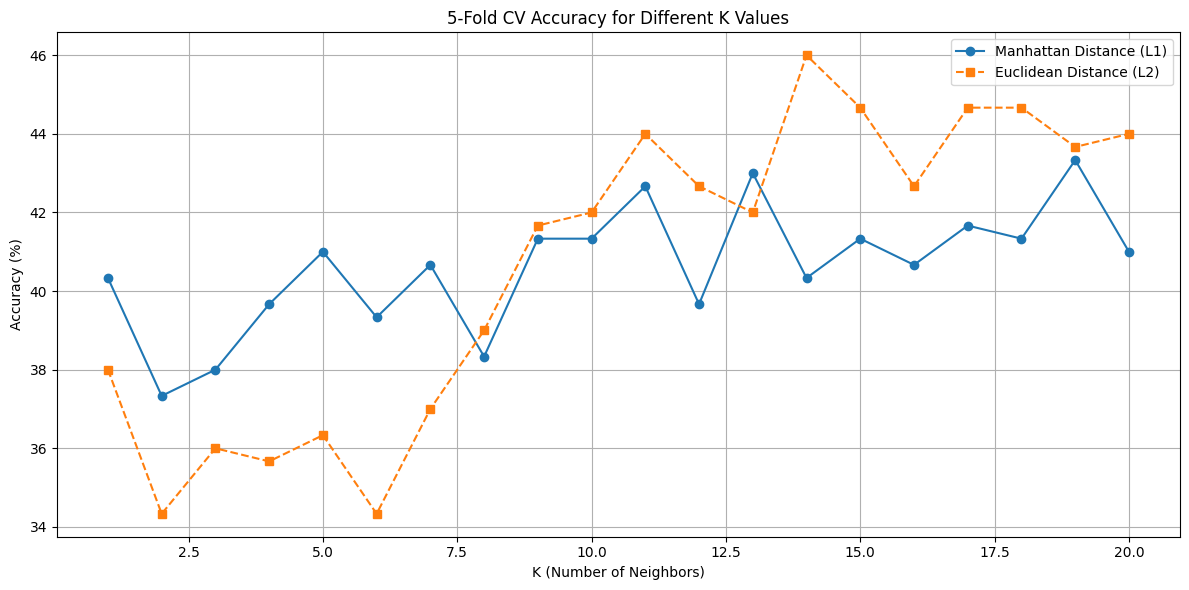


======= PERFORMANCE SUMMARY =======
Best Manhattan (L1) Accuracy : 43.33% at K = 19
Best Euclidean (L2) Accuracy : 46.00% at K = 14


In [24]:

# ===== Visualization & Result Summary =====

if len(X) > 0:


    plt.figure(figsize=(12, 6))
    plt.plot(k_values,
             np.array(results["Manhattan"]) * 100,
             label="Manhattan Distance (L1)",
             marker="o")

    plt.plot(k_values,
             np.array(results["Euclidean"]) * 100,
             label="Euclidean Distance (L2)",
             marker="s",
             linestyle="--")

    plt.title("5-Fold CV Accuracy for Different K Values")
    plt.xlabel("K (Number of Neighbors)")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    best_L1 = np.argmax(results["Manhattan"])
    best_L2 = np.argmax(results["Euclidean"])

    print("\n======= PERFORMANCE SUMMARY =======")
    print(f"Best Manhattan (L1) Accuracy : {results['Manhattan'][best_L1] * 100:.2f}% at K = {k_values[best_L1]}")
    print(f"Best Euclidean (L2) Accuracy : {results['Euclidean'][best_L2] * 100:.2f}% at K = {k_values[best_L2]}")



--- TOP 5 Predictions on Random Images ---

Image Index: 133


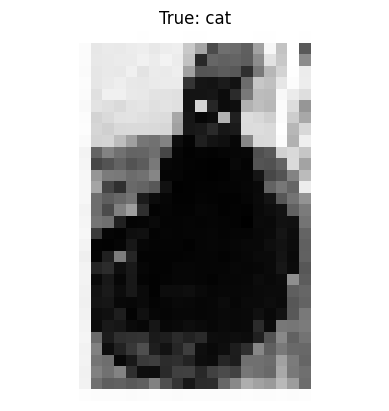

Pred (Manhattan): cat
Pred (Euclidean): cat

Image Index: 10


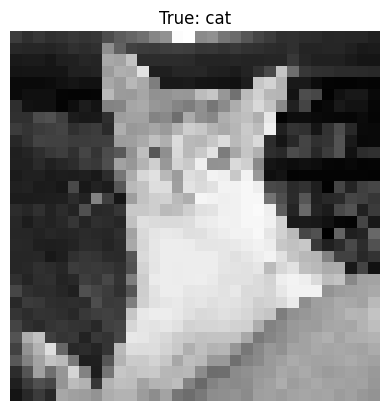

Pred (Manhattan): cat
Pred (Euclidean): dog

Image Index: 47


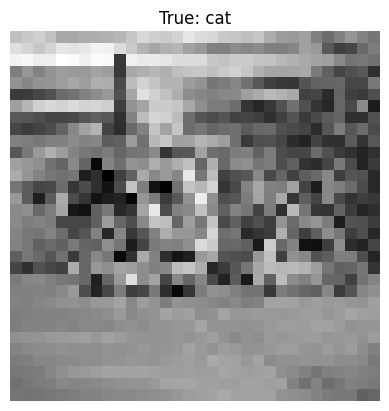

Pred (Manhattan): dog
Pred (Euclidean): panda

Image Index: 154


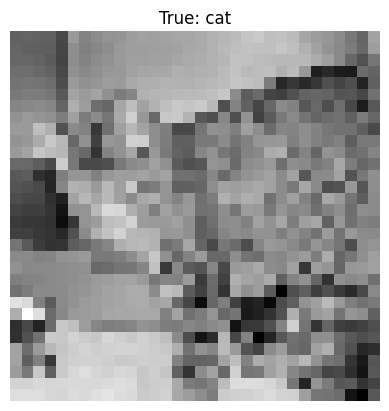

Pred (Manhattan): cat
Pred (Euclidean): panda

Image Index: 23


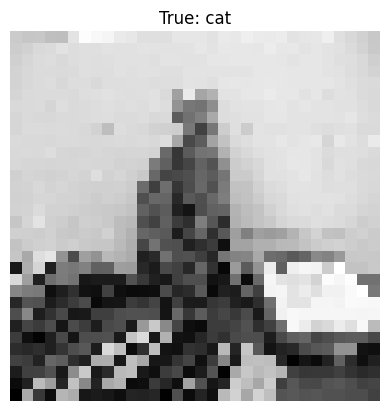

Pred (Manhattan): cat
Pred (Euclidean): cat


In [22]:
# ----- TOP 5 PREDICTIONS -----

print("\n\n--- TOP 5 Predictions on Random Images ---")

num_samples = 5
sample_indices = np.random.choice(len(X), num_samples, replace=False)

for idx in sample_indices:
    img = X[idx]
    true_label = classes[y[idx]]

    pred_L1 = k_nearest_neighbors(X, y, img, k=3, distance_metric=manhattan_distance)
    pred_L2 = k_nearest_neighbors(X, y, img, k=3, distance_metric=euclidean_distance)

    print("\nImage Index:", idx)
    plt.imshow(img.reshape(32, 32), cmap='gray')
    plt.title(f"True: {true_label}")
    plt.axis('off')
    plt.show()

    print(f"Pred (Manhattan): {classes[pred_L1]}")
    print(f"Pred (Euclidean): {classes[pred_L2]}")
